<h1 style="font-size: 40px; margin-bottom: 0px;">15.1 Multiomics and functional analysis</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

In notebook 13-1, we explored our transcriptome data at the level of each gene, and today, we'll take a look at our data with respect to groups of genes through a functional analysis of our differential expression results. While looking at the changes in expression of individual genes can provide insight into the gene-level impacts of experimental manipulations, we can also look for groups of genes that change together through functional analysis. This type of analysis can give us insight into broader biological changes that are occurring as a result of experimental manipulations, such as knocking down TAZ. So rather than asking about what is happening to a specific gene, we are instead asking about what biological processes, signaling pathways, or other functional groups are changing in our cells.

Of particular interest to us is also how our transcriptome analysis intersects with our ChIP analysis. Recall that from our ChIP-seq analysis, we identified a set of reproducible peaks where TAZ-TEAD are likely to bind to DNA. Our analysis showed that TAZ-TEAD primarily bind to regions distant from the transcription start site (TSS) rather than the nearby promoter region, suggesting a longer range regulation of target gene expression through distant enhancers. 

In this notebook, we'll be taking a basic multiomics approach by integrating our two big data analyses together in order to identify overlapping sets of genes from our two analyses. This approach can give us insight into the regulation of TAZ target genes and potentially identify some direct targets of TAZ and determine how TAZ regulates their transcription. We'll then take a look to see what functional groups are directly affected by TAZ KO compared to the overall changes that we see when we look at the full transcriptomic profile.

<strong>Learning objectives:</strong>
<ul>
    <li>Identify intersections between datasets</li>
    <li>Explore databases for functional analysis</li>
    <li>Review and perform an over-representation analysis</li>
    <li>Review and perform gene set enrichment analysis (GSEA)</li>
</ul>

<h1 style="font-size: 40px; margin-bottom: 0px;">Load in packages</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

To visualize intersections, we'll make use of a package called <code>BioVenn</code>, which was developed by Tim Hulsen (<a href="https://journals.sagepub.com/doi/10.3233/DS-210032" rel="noopener noreferrer"><u>Hulsen 2021</u></a>). It allows us to readily pull together our datasets and visualize their intersections as a Venn diagram. Another common way to visualize Venn diagrams is <code>matplotlib-venn</code>, which allows for a bit more customization, but won't simultaneously identify intersections.

<a href="https://pypi.org/project/BioVenn/" rel="noopener noreferrer"><u>Documentation for <code>BioVenn</code> can be found here.</u></a>

<a href="https://pypi.org/project/matplotlib-venn/" rel="noopener noreferrer"><u>Documentation for <code>matplotlib-venn</code> can be found here.</u></a>

We'll be performing both the over-representation analysis and GSEA using Python, and to do this, we'll make use of a package called <code>GSEApy</code>, which was developed by Zhuoqing Fang, Xinyuan Liu, and Gary Peltz (<a href="https://academic.oup.com/bioinformatics/article/39/1/btac757/6847088" rel="noopener noreferrer"><u>Fang et al 2022</u></a>). It also allows us to directly pull into our notebook, a bunch of different databases all containing their own gene sets, which we can then use to identify functional groups that may be impacted when we knocked down TAZ.

<a href="https://gseapy.readthedocs.io/en/latest/index.html" rel="noopener noreferrer"><u>Documentation for <code>GSEApy</code> can be found here.</u></a>

In [1]:
pip install BioVenn

  Using cached BioVenn-1.1.3-py3-none-any.whl.metadata (5.3 kB)
  Using cached biomart-0.9.2-py3-none-any.whl.metadata (3.3 kB)
Using cached BioVenn-1.1.3-py3-none-any.whl (21 kB)
Using cached biomart-0.9.2-py3-none-any.whl (12 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [BioVenn]
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install gseapy

  Using cached gseapy-1.1.11-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
Using cached gseapy-1.1.11-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (605 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import BioVenn as bv
import seaborn as sns
import scipy.stats as stats
import gseapy as gp
import os

<h1 style="font-size: 40px; margin-bottom: 0px;">Load in ChIP-seq and RNA-seq data</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

<h2>Load in RNA-seq data</h2>

Let's go ahead and load in our RNA-seq differential expression results that we got from <code>DESeq2</code>.

In [4]:
res = pd.read_csv('../Week_10/differential-expression-analysis/1M_results.csv')

Then now let's take a quick sanity check to make sure it imported properly.

In [5]:
res.head().style

,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,A1BG-AS1,1.717396,1.579446,0.747265,2.113634,0.034547,0.105928
1,A4GALT,10.639844,-0.064188,0.276068,-0.232508,0.816143,0.904300
2,AAAS,28.134083,-0.029254,0.173522,-0.168591,0.866118,0.930518
3,AACS,28.101282,-0.139976,0.158908,-0.880861,0.378393,0.577812
4,AADAT,3.955065,0.101844,0.421201,0.241794,0.808940,0.901120


We'll need to use the first column because it contains the gene names that we'll use to identify intersections with our ChIP-seq dataset, so let's go ahead and update the column header to <code>'gene'</code>.

In [6]:
res.rename(columns={res.columns[0] : 'gene'},
           inplace=True
          )

In [7]:
res.head().style

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,A1BG-AS1,1.717396,1.579446,0.747265,2.113634,0.034547,0.105928
1,A4GALT,10.639844,-0.064188,0.276068,-0.232508,0.816143,0.904300
2,AAAS,28.134083,-0.029254,0.173522,-0.168591,0.866118,0.930518
3,AACS,28.101282,-0.139976,0.158908,-0.880861,0.378393,0.577812
4,AADAT,3.955065,0.101844,0.421201,0.241794,0.808940,0.901120


<h2>Load in ChIP-seq data</h2>

Now let's load in our ChIP-seq data. Recall that we can use HOMER to annotate peaks based on the nearest TSS to get an idea of what gene each peak may potentially be regulating. In this week's directory, there is a <code>data</code> subdirectory containing an annotated peaks file generated by HOMER for the full ChIP-seq dataset. For this notebook, we'll make use of the full set to be able to work with more peaks identified as significantly enriched when pulling down TAZ.

First, let's go ahead and load in our annotated peaks.

In [8]:
peaks = pd.read_csv('./data/annotated-peaks-full-set.txt',
                    sep='\t',
                   )

#This dataset was obtained from our full set ChIP-seq analysis not the truncated one
#Which gives us (as you probably saw from your homework results) a lot more merged peaks to play with
#We can take the merged peaks from the top 2000 or so that are concordant (rather than top 500 like we did with our truncated data)
#That gives us a lot of peaks to play with and then we can use HOMER to annotate them based on the nearest TSS
#Recall from Dr. Ingolia's Week 15 lecture that annotating peaks based on nearest TSS is a common way to infer what gene is regulated by a ChIP-peak

Now let's perform a quick sanity check and take a look at the dataset.

In [9]:
peaks
#What is particularly important for us is the gene type and the gene name

,PeakID (cmd=annotatePeaks.pl ./top_concordant_peaks_full-set.narrowPeak hg19 -noann),Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,Nearest PromoterID,Entrez ID,Nearest Unigene,Nearest Refseq,Nearest Ensembl,Gene Name,Gene Alias,Gene Description,Gene Type
0,Merged-chr19-39184227-2,chr19,39184140,39184315,+,0.0,/home/jovyan/shared/course/mcb201b-shared/chip...,NaN,NaN,45938,NM_001322033,81.0,NaN,NM_004924,ENSG00000130402,ACTN4,ACTININ-4|FSGS|FSGS1,actinin alpha 4,protein-coding
1,Merged-chr10-91038033-2,chr10,91037981,91038085,+,0.0,/home/jovyan/shared/course/mcb201b-shared/chip...,NaN,NaN,-23770,NM_001547,3433.0,NaN,NM_001547,ENSG00000119922,IFIT2,G10P2|GARG-39|IFI-54|IFI-54K|IFI54|IFIT-2|ISG-...,interferon induced protein with tetratricopept...,protein-coding
2,Merged-chr2-65886199-2,chr2,65886111,65886288,+,0.0,/home/jovyan/shared/course/mcb201b-shared/chip...,NaN,NaN,-226466,NM_181784,200734.0,NaN,NM_181784,ENSG00000198369,SPRED2,NS14|Spred-2,sprouty related EVH1 domain containing 2,protein-coding
3,Merged-chr19-48991373-2,chr19,48991289,48991457,+,0.0,/home/jovyan/shared/course/mcb201b-shared/chip...,NaN,NaN,18747,NM_004228,9266.0,NaN,NM_004228,ENSG00000105443,CYTH2,ARNO|CTS18|CTS18.1|PSCD2|PSCD2L|SEC7L|Sec7p-L|...,cytohesin 2,protein-coding
4,Merged-chr6-50055081-2,chr6,50055014,50055148,+,0.0,/home/jovyan/shared/course/mcb201b-shared/chip...,NaN,NaN,-37439,NM_001369057,245915.0,NaN,NM_001037498,ENSG00000180872,DEFB112,DEFB-12,defensin beta 112,protein-coding
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1864,Merged-chr17-855149-2,chr17,855097,855201,+,0.0,/home/jovyan/shared/course/mcb201b-shared/chip...,NaN,NaN,27867,NM_022463,64359.0,NaN,NM_022463,ENSG00000167693,NXN,NRX|RRS2|TRG-4,nucleoredoxin,protein-coding
1865,Merged-chr14-23398869-2,chr14,23398813,23398925,+,0.0,/home/jovyan/shared/course/mcb201b-shared/chip...,NaN,NaN,51,NR_110002,101926933.0,NaN,NR_110002,ENSG00000257285,PRMT5-DT,-,PRMT5 divergent transcript,ncRNA
1866,Merged-chr4-77532537-2,chr4,77532472,77532602,+,0.0,/home/jovyan/shared/course/mcb201b-shared/chip...,NaN,NaN,35833,NR_039655,100616254.0,NaN,NR_039655,ENSG00000283682,MIR548AH,-,microRNA 548ah,ncRNA
1867,Merged-chr6-37210436-2,chr6,37210351,37210521,+,0.0,/home/jovyan/shared/course/mcb201b-shared/chip...,NaN,NaN,14939,NM_145316,221468.0,NaN,NM_145316,ENSG00000172738,TMEM217,C6orf128|dJ355M6.2,transmembrane protein 217,protein-coding


<h1 style="font-size: 40px; margin-bottom: 0px;">Identify and visualize intersection between datasets</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

Now that we have both datasets loaded in, let's proceed with identifying their intersections.

What we're interested in is the gene names, and recall that our library was based on RNA samples that were enriched for mRNA. So we're particularly interested in the gene names for protein-coding genes since that is what we're analyzing with our RNA-seq data.

Let's go ahead and pull out the gene names from our datasets.

<h2>Pull out gene names for genes that are differentially expressed</h2>

We'll first pull out genes that are significantly differentially expressed based on our RNA-seq analysis p-adjusted values.

In [10]:
res

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,A1BG-AS1,1.717396,1.579446,0.747265,2.113634,0.034547,0.105928
1,A4GALT,10.639844,-0.064188,0.276068,-0.232508,0.816143,0.904300
2,AAAS,28.134083,-0.029254,0.173522,-0.168591,0.866118,0.930518
3,AACS,28.101282,-0.139976,0.158908,-0.880861,0.378393,0.577812
4,AADAT,3.955065,0.101844,0.421201,0.241794,0.808940,0.901120
...,...,...,...,...,...,...,...
17301,ZYG11A,6.760829,-0.063447,0.361171,-0.175671,0.860552,0.926733
17302,ZYG11B,30.511184,0.004179,0.170884,0.024453,0.980491,0.994338
17303,ZYX,144.918149,-0.324147,0.088009,-3.683103,0.000230,0.001677
17304,ZZEF1,28.852060,0.103463,0.219259,0.471875,0.637016,0.789957


In [19]:
#We can apply a filter for what we want to focus on, specifically we can pull out significant genes
#We can use these gene names to then find which ones are shared with our ChIP-seq dataset
de_genes = res.loc[(res['padj'] < 0.05), 'gene']

In [13]:
#Let's take a look to see what is pulled out
#These are just genes identified as significant from just RNA-seq differential expression analysis
#We haven't identified intersections yet
de_genes[0:10]

58       ABCG1
59       ABCG2
84      ABI3BP
108      ACADS
127      ACKR3
160      ACTA2
191     ACVR2A
202     ADAM12
213      ADAM8
215    ADAMTS1
Name: gene, dtype: object

<h2>Pull out gene names for protein-coding genes</h2>

You can see that the annotations identify the <code>'Gene Type'</code>, which we can use to pull out just the protein-coding genes.

In [14]:
#Our RNA-seq is on mRNA, so we're focusing on protein-coding genes
#So we can also pull those out from our ChIP peak annotation table to get our list of ChIP genes
chip_genes = peaks.loc[peaks['Gene Type'] == 'protein-coding', 'Gene Name']

In [15]:
chip_genes[0:10]

0      ACTN4
1      IFIT2
2     SPRED2
3      CYTH2
4    DEFB112
5    CCDC115
6       SYBU
7    TMEM45A
8       MYH9
9      ILDR2
Name: Gene Name, dtype: object

<h2>Generate an empty list</h2>

If we dig into the documentation for <code>BioVenn</code>, you can see that there is a quirk in terms of how the function is set up. It's built to identify and visualize intersections of three datasets, and since we're only interested in comparing our two datasets, we can get around this by feeding it an empty list, which will satisfy it's requirements.

In [16]:
the_void = []
#The draw_venn() function requires 3 lists, so we can just give it an empty one to satisfy its required parameters
#nothing will intersect with this so it's effectively ignored

<h2>Visualize intersections as a Venn diagram</h2>

With our lists of gene names from our datasets (and one empty one), we can generate a Venn diagram using <code>BioVenn</code>.

x total: 3574
y total: 1028
z total: 0
x only: 3255
y only: 709
z only: 0
x-y total overlap: 319
x-z total overlap: 0
y-z total overlap: 0
x-y only overlap: 319
x-z only overlap: 0
y-z only overlap: 0
x-y-z overlap: 0


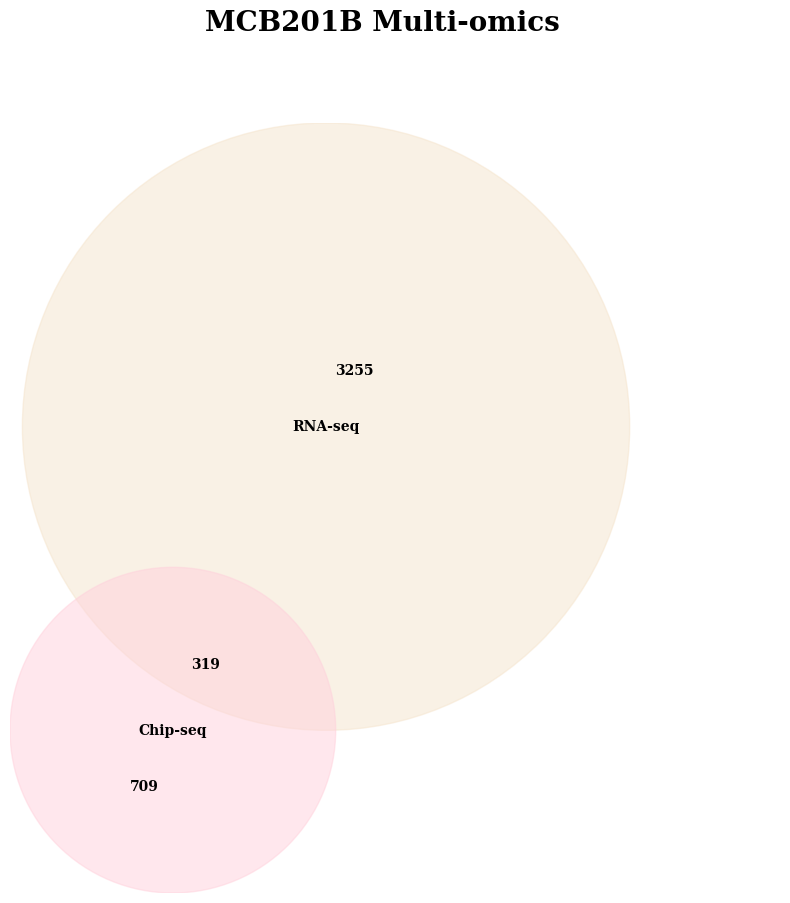

In [20]:
#Now we can draw our Venn diagram to visualize the intersection
#The draw_venn() function will output a visualization as well as a dictionary of results corresponding to different intersections
venn = bv.draw_venn(list_x=de_genes,                 #We give it our first list - our RNAseq hits
                    list_y=chip_genes,               #and then our second one - our ChIPseq hits
                    list_z=the_void,                 #and our empty list
                    title='MCB201B Multi-omics',     #update title
                    subtitle=None,                   #remove the default subtitle
                    xtitle='RNA-seq',                #update label for our list_x (rnaseq)
                    ytitle='Chip-seq',               #update the label for our list_y (chipseq)
                    x_c='#F5E4CC',                   #update color for list_x circle in Venn diagram
                    y_c='#FFD1DC',                   #update color for list_y circle in Venn diagram
                   )

<h2>Identify the overlapping genes</h2>

Let's go ahead and identify the differentially expressed genes that also correspond to a peak based on our analyses.

While the documentation is a bit limited, we can see from the paper <a href="https://journals.sagepub.com/doi/10.3233/DS-210032" rel="noopener noreferrer"><u>Hulsen 2021</u></a> that the returned objects for different set operations can be pulled out of our <code>venn</code> variable, and specifically we can pull out the intersection between <code>list_x</code> and <code>list_y</code> as <code>xy_only</code>.

In [22]:
#The output is a dictionary that we can then pull out what we're interested using their key
venn['xy_only'][0:10]
#Here we pull out the intersection between list_x and list_y, which is our rna-seq and our chip-seq datasets

['ADAM19',
 'TENM2',
 'LRP3',
 'RGMB',
 'SLC1A3',
 'ADGRF5',
 'ARHGAP24',
 'ATP8B1',
 'PALLD',
 'ZBTB18']

We can also do it ourselves using set operators to identify the intersection.

In [23]:
type(de_genes)

pandas.core.series.Series

In [25]:
#We can use set operators to do the same thing that draw_venn() does when it generates the Venn diagram
list(set(de_genes) & set(chip_genes))[0:10]
#The extra list notation is just to pull out the first 10, so it's not outputting everything
#Recall from lecture that the intersection tells us that these differentially expressed genes are likely direct targets of TAZ

['SLC1A3',
 'ADGRF5',
 'ZBTB18',
 'DEK',
 'PLXNA1',
 'MTUS1',
 'NRP1',
 'NSD1',
 'LIMA1',
 'CYTH3']

What can we infer about this set of overlapping genes in terms of how TAZ is regulating them?

<h2>Identify the differentially expressed genes without a peak</h2>

Let's go ahead and also pull out the differentially expressed genes that don't correspond to a ChIP-seq peak. In other words, we would be identifying the genes that are present from our RNA-seq analysis but not in our ChIP-seq annotation. We can pull these out from our <code>venn</code> object, or we can identify these genes using set operators.

In [26]:
#We can pull out the difference as well, specifically just our RNA-seq hits that DO NOT intersect with our ChIP peaks
venn['x_only'][0:10]

['GAPVD1',
 'TEPP',
 'CHCHD3',
 'DDX39A',
 'TUBB6',
 'GLYR1',
 'YWHAE',
 'CYP1B1',
 'TFAP2C',
 'GPRC5A']

In [27]:
#We can also do the same with set operators to find the difference
list(set(de_genes) - set(chip_genes))[0:10]

#These genes are likely indirectly regulated by TAZ
#Since they don't intersect with a ChIP peak, it's possible that things directly regulated by TAZ
#or other secondary changes within the cell drive the changes in gene expression that we see with these genes

['GAPVD1',
 'TEPP',
 'CHCHD3',
 'DDX39A',
 'TUBB6',
 'GLYR1',
 'YWHAE',
 'CYP1B1',
 'TFAP2C',
 'UROS']

How are these genes different than the overlapping set of genes in terms of how TAZ is regulating them?

<h1 style="font-size: 40px; margin-bottom: 0px;">Exercise: Compare expression changes between directly and indirectly regulated genes</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

For this exercise, take a look at the expression changes between genes directly regulated by TAZ and those that have their expression impacted based on more indirect regulation/effects.

<h2>1. Create DataFrames for overlapping and non-overlapping sets containing <code>DESeq2</code> results</h2>

For this part, you can set up two DataFrames, one for the overlapping set and the other for the non-overlapping set (RNA-seq only) with the <code>DESeq2</code> results pulled into them.

In [28]:
#We can then use the pd.Series.isin() function to pull out the information just for genes contained within the intersection
overlap = res.loc[res.gene.isin(venn['xy_only']), :]
#So this would just be information on genes that are directly regulated by TAZ

In [29]:
overlap.head().style

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
84,ABI3BP,2.217591,-3.911127,0.806348,-4.850422,0.000001,0.000015
97,ABTB2,24.241325,0.442388,0.171200,2.584034,0.009765,0.039476
115,ACAT2,58.251661,-0.310600,0.113016,-2.748280,0.005991,0.026466
173,ACTN1,527.742339,-0.292663,0.062124,-4.710941,0.000002,0.000029
175,ACTN4,1001.076407,-0.293635,0.055564,-5.284628,0.000000,0.000002


In [30]:
#We can use the same setup to also pull those that are indirect targets
no_overlap = res.loc[res.gene.isin(venn['x_only']), :]

In [31]:
no_overlap.head().style

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
11,AARS1,75.605433,-0.433385,0.100656,-4.305609,0.000017,0.000164
21,ABCA1,41.210361,-0.653427,0.163851,-3.987933,0.000067,0.000564
26,ABCA2,65.941915,0.342784,0.119841,2.860329,0.004232,0.020035
27,ABCA3,32.013130,0.697068,0.193700,3.598708,0.000320,0.002232
31,ABCA7,10.881120,-0.842159,0.288254,-2.921590,0.003483,0.017020


<h2>2. Visualize distribution of <code>'log2FoldChange'</code> for both sets</h2>

Once you have the <code>DESeq2</code> results corresponding to each set, visualize the distribution of the expression changes between the two to see if there may be differences in how the loss of TAZ affects their expression.

<Axes: xlabel='log2FoldChange', ylabel='Proportion'>

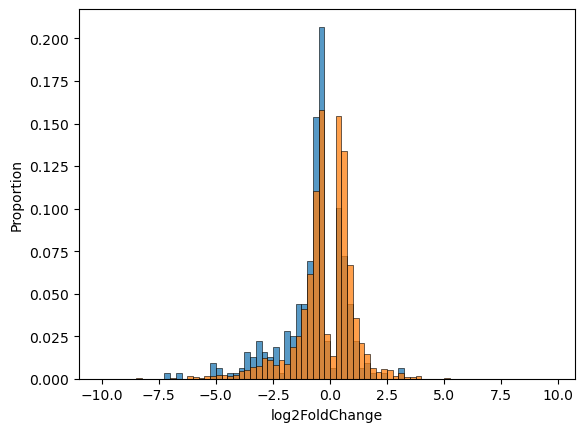

In [33]:
#Let's take a look at the distribution of the expression changes for direct vs indirect targets
#We can plot a histogram for the direct targets' log2FoldChange
sns.histplot(overlap.log2FoldChange,
             bins=np.arange(-10, 10, 0.25),
             stat='proportion',
             label='overlapping',
            )

#We can also do the same for the indirect targets' log2FoldChange
sns.histplot(no_overlap.log2FoldChange,
             bins=np.arange(-10, 10, 0.25),
             stat='proportion',
             label='non-overlapping',
            )

#We set stat='proportion' to more easily compare the distributions visually

<h2>3. Determine if there is a statistically significant difference in their distribution</h2>

See if you can set up a Mann-Whitney U-test to determine if there is a significant difference between their distributions.

In [34]:
#Can see maybe there is a difference in the distribution
#Let's check statistically if there is a difference
stats.mannwhitneyu(overlap.log2FoldChange,
                   no_overlap.log2FoldChange,
                  )

#We can see in this case that there is

MannwhitneyuResult(statistic=397436.0, pvalue=4.468576593091868e-12)

What does the distribution tell us about how TAZ loss impacts the genes that are directly regulated vs indirectly regulated?

<h1 style="font-size: 40px; margin-bottom: 0px;">Functional analysis of RNA-seq results</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

Here, we'll proceed with a functional analysis of our RNA-seq results, and then we'll also run the analysis on our set of genes identified as potentially regulated directly by TAZ.

<h2>Explore databases</h2>

Recall from Dr. Ingolia's lecture that there are a large number of different databases curated by different organizations and people. Each database will group genes a little differently depending on their own classification scheme, and so selecting a database can affect how you interpret your functional analysis. Some may allow you to gain insight into the regulation of different pathways and others may provide information on how biological processes are altered in your experimental manipulation.

Let's briefly take some time to take a look at some databases to see how they organize their gene sets.

<h2>Pull in Molecular Signatures Database (MSigDB)</h2>

One of the major databases is the <a href="https://www.gsea-msigdb.org/gsea/msigdb" rel="noopener noreferrer"><u>Molecular Signatures Database (MSigDB)</u></a>, which contains annotated gene sets for functional analysis. MSigDB is a joint project between UC San Diego and the Broad Institute (<a href="https://www.pnas.org/doi/10.1073/pnas.0506580102" rel="noopener norferrer"><u>Subramanian, Tamayo et al 2005</u></a>, <a href="https://pmc.ncbi.nlm.nih.gov/articles/PMC4707969/" rel="noopener norferrer"><u>Liberzon et al 2015</u></a>) and funded by the National Cancer Institute's Informatics Technology for Cancer Research.

<code>GSEApy</code> allows us to pull in information on the current <a href="https://data.broadinstitute.org/gsea-msigdb/msigdb/release/" rel="noopener noreferrer"><u>MSigDB database from the Broad Institute.</u></a>

To do this, we'll make use of the <code>gp.Msigdb()</code> function from the GSEApy package.

In [35]:
#To better understand these parts, explore the Molecular Signatures DataBase (the first and last links in the above markdown cell)
msig = gp.Msigdb()
#Here, we're pulling in information of the directories for the MsSigDB database releases

In [36]:
#We can take a look at the object
msig
#Which isn't the most informative for us

We can then take a look to see what directories the server currently has:

In [37]:
#But we can pull out the information within the object
msig.list_dbver()
#We can see the directories containing the different MSigDB releases
#Can see that MSigDB contains curated gene sets for mice (Mus musculus (Mm)) and humans (Homo sapiens (Hs))
#To better understand, go into the releases for MSigDB using the link contained in the link for "MSigDB databse from the Broad Institute"
#You'll be able to manually navigate through the different files
#Information on the annotations like c5 or h are better explained in the link for "Molecular Signatures Database (MSigDB)" link
#h stands for Hallmark gene sets
#c5 is the gene ontology one
#Both are commonly used and other ones are also commonly used like KEGG

,Name,Last modified
0,6.0,2018-12-17 16:29
1,6.1,2018-12-17 16:29
2,6.2,2018-12-17 16:29
3,7.0,2020-01-27 04:43
4,7.1,2020-03-30 16:55
5,7.2,2020-09-18 23:33
6,7.3,2021-03-22 15:09
7,7.4,2021-04-02 14:38
8,7.5.1,2023-03-09 19:38
9,7.5,2022-01-13 01:00


To get the <code>gmt</code> file, we will make use of the function <code>msig.get_gmt()</code>, where <code>msig</code> is the <code>msigdb</code> object that we created earlier with the <code>Msigdb()</code> function.

In [38]:
#Here we'll pull in all the Hallmark gene sets contained within the 2025 release for humans
#Category specifies essentially what is the gmt file we want and dbver specifies the release version
hallmark_db = msig.get_gmt(category='h.all', dbver='2025.1.Hs')

In [45]:
#Can see that we get a dictionary
#The dictionary contains key:value pairs
#the keys are the different Hallmark gene sets like HALLMARK_ADIPOGENESIS
#the values are all the genes annotated to that specific grouping
#When we run our functional analysis, we'll be taking a look to see if there is enrichment within our results compared to what would be expected by chance
type(hallmark_db)
#The functional groupings then give us an idea of what biological process or moelcular function or signaling pathway etc
#is being changed following TAZ KO
#Which can form the basis for potential further questions to explore (like for your final project)

dict

<h2>Let's break down the code:</h2>

<code>hallmark_db</code>

This is the variable that we will save our database. The database is imported into Python as a <code>dict</code> (dictionary) object, so it has <code>key:value</code> pairs, where the key is the category or group that a gene or genes belong to, and the value is the gene name. 

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>&equals;</code>

Our assignment operator.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>msig.get_gmt()</code>

This function allows us to pull in the database that we want to use for our functional analysis. The files are usually in a <a href="https://software.broadinstitute.org/cancer/software/gsea/wiki/index.php/Data_formats#GMT:_Gene_Matrix_Transposed_file_format_.28.2A.gmt.29" rel="noopener noreferrer"><u>.gmt (Gene Matrix Transposed) format</u></a>.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>category='h.all'</code>

This is the database that we want to pull in, since if we take a look at the directory, it contains a bunch of different .gmt files. Here, we're pulling in the MSigDB Hallmark database.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>dbver='2025.1.Hs'</code>

This is the database version that we're pulling in. As you saw when we took a look at the <code>msigdb</code> object, there were different versions of the MSigDB for both humans and mice, and the <code>dbver</code> parameter allows us to select which version we want to pull into our notebook.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

Since the object is a dictionary, we can pull all the values associated with a specific key. In other words, pull all the genes associated with a specific MSigDB Hallmark category.

In [42]:
hallmark_db['HALLMARK_HEDGEHOG_SIGNALING'][0:10]

['ACHE',
 'ADGRG1',
 'AMOT',
 'CDK5R1',
 'CDK6',
 'CELSR1',
 'CNTFR',
 'CRMP1',
 'DPYSL2',
 'ETS2']

What you should see is a list of genes that have been categorized as being involved in adipogenesis by MSigDB. We can also take a look at the whole database by converting the dictionary to a DataFrame:

In [44]:
#This is just to let us more easily see all the Hallmark gene sets at once
#Keep in mind that gene sets can have different numbers of genes annotated to them
#So it's not required that every gene set has the same number of genes
#You can also see that a single gene can be annotated to more than one gene set as well
#Which isn't too suprising since we know that a gene can be involved in multiple things
pd.DataFrame.from_dict(hallmark_db, orient='index').T

,HALLMARK_ADIPOGENESIS,HALLMARK_ALLOGRAFT_REJECTION,HALLMARK_ANDROGEN_RESPONSE,HALLMARK_ANGIOGENESIS,HALLMARK_APICAL_JUNCTION,HALLMARK_APICAL_SURFACE,HALLMARK_APOPTOSIS,HALLMARK_BILE_ACID_METABOLISM,HALLMARK_CHOLESTEROL_HOMEOSTASIS,HALLMARK_COAGULATION,...,HALLMARK_PROTEIN_SECRETION,HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY,HALLMARK_SPERMATOGENESIS,HALLMARK_TGF_BETA_SIGNALING,HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,HALLMARK_UV_RESPONSE_DN,HALLMARK_UV_RESPONSE_UP,HALLMARK_WNT_BETA_CATENIN_SIGNALING,HALLMARK_XENOBIOTIC_METABOLISM
0,ABCA1,AARS1,ABCC4,APOH,ACTA1,ADAM10,ADD1,ABCA1,ABCA2,A2M,...,ABCA1,ABCC1,ACE,ACVR1,ABCA1,ALDH18A1,ABCC1,ABCB1,ADAM17,ABCC2
1,ABCB8,ABCE1,ABHD2,APP,ACTB,ADIPOR2,AIFM3,ABCA2,ACAT2,ACOX2,...,ADAM10,ATOX1,ACRBP,APC,ACKR3,ARFGAP1,ACVR2A,ACAA1,AXIN1,ABCC3
2,ACAA2,ABI1,ACSL3,CCND2,ACTC1,AFAP1L2,ANKH,ABCA3,ACSS2,ADAM9,...,ANP32E,CAT,ACRV1,ARID4B,AREG,ASNS,ADD3,AGO2,AXIN2,ABCD2
3,ACADL,ACHE,ACTN1,COL3A1,ACTG1,AKAP7,ANXA1,ABCA4,ACTG1,ANG,...,AP1G1,CDKN2D,ACTL7B,BCAR3,ATF3,ATF3,ADGRL2,ALAS1,CCND2,ABHD6
4,ACADM,ACVR2A,ADAMTS1,COL5A2,ACTG2,APP,APP,ABCA5,ADH4,ANXA1,...,AP2B1,EGLN2,ADAD1,BMP2,ATP2B1,ATF4,ADORA2B,ALDOA,CSNK1E,ACO2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,UQCR11,UBE2D1,None,None,VWF,None,None,None,None,None,...,None,None,None,None,VEGFA,None,None,None,None,UPB1
196,UQCRC1,UBE2N,None,None,WASL,None,None,None,None,None,...,None,None,None,None,YRDC,None,None,None,None,UPP1
197,UQCRQ,WARS1,None,None,WNK4,None,None,None,None,None,...,None,None,None,None,ZBTB10,None,None,None,None,VNN1
198,VEGFB,WAS,None,None,YWHAH,None,None,None,None,None,...,None,None,None,None,ZC3H12A,None,None,None,None,VTN


For this version of the MSigDB Hallmark human database, you can see that there are 50 different categories ranging from adipogenesis to xenobiotic metabolism with varying numbers of genes inside of them. <a href="https://www.gsea-msigdb.org/gsea/msigdb/human/genesets.jsp?collection=H" rel="noopener noreferrer"><u>We can also find more information on these gene sets by diving into the MSigDB page on their Hallmark database.</u></a>

<h2>Use GSEApy to pull Enrichr library of databases</h2>

GSEApy also functions as an Enrichr wrapper, meaning that it allows you to use the Enrichr web program through Python. <a href="https://maayanlab.cloud/Enrichr/" rel="noopener noreferrer"><u>Enrichr is developed and maintained by the Ma'ayan lab at the Icahn School of Medicine, Mount Sinai, Center for Bioinformatics</u></a> (<a href="https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-14-128" rel="noopener noreferrer"><u>Chen et al 2013</u></a>), and it's one of many web-based tools/programs that allow you to perform functional analyses, such as the ones we're doing in this lesson.

To take a look at what human-specific databases we can work with for functional analysis, we can make use of the <code>gp.get_library_name()</code> function.

In [46]:
#This example is another way to pull in other databases too
#Here we'll pull from Enrichr - see the Enrichr link in the Markdown cell above
databases = gp.get_library_name(organism='Human')

Let's take a look at what we pulled into our notebook:

In [48]:
#Just outputing the first 10 databases that we pulled in from Enrichr
databases[0:10]

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021']

You should see that we now have a long list of different human-specific databases that have categorized genes in a variety of different ways.

Some commonly used ones that Dr. Ingolia mentioned in lecture are those databases from the <a href="https://geneontology.org/" rel="noopener noreferrer"><u>Gene Ontology (GO) resource</u></a>, the MSigDB, and the <a href="https://www.genome.jp/kegg/" rel="noopener noreferrer"><u>Kyoto Encyclopedia of Genes and Genomes (KEGG)</u></a>. Recall that GO is at the highest level of grouping, divided into three major categories: biological process, cell component, and molecular function, and you should be able to see in this list of databases, these three categories as their own database for functional analysis.

Note that these are pulled from the Enrichr library, and that they might not always be the most up-to-date. Note the date for their repository of the MSigDB Hallmark database, <code>MSigDB_Hallmark_2020</code>, while we can directly download or pull the most up-to-date version directly from MSigDB.

<h2>Using databases</h2>

These databases often can be used through web or desktop programs that have been developed, and we'll explore some of them towards the end of this lesson if we have time.

To use these databases via <code>GSEApy</code>, we can just pass the name or the variable for the gene set that we want to use for our functional analysis.

<h1 style="font-size: 40px; margin-bottom: 0px;">Load in and prepare data</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

Let's go ahead and load in our RNA-seq data that we'll use for this part of our notebook:

In [49]:
#Let's now go ahead and load in our data so we can play around with some functional analyses
#We'll be focusing on over-representation analysis and gene set enrichment analysis (GSEA)
#These two are fairly common approaches to look for enrichment of functional groups or processes etc
#We'll use normalized counts for GSEA and shrunken logfoldchange for over-representation analysis
norm_counts = pd.read_csv('../Week_10/differential-expression-analysis/1M_class_norm_counts.csv')
shrinklfc = pd.read_csv('../Week_10/differential-expression-analysis/1M_results_lfcShrink.csv')

Let's take a look at our imported data as a sanity check.

In [51]:
shrinklfc.head().style

,Unnamed: 0,baseMean,log2FoldChange,lfcSE,pvalue,padj
0,A1BG-AS1,1.717396,0.530432,0.753164,0.034547,0.105928
1,A4GALT,10.639844,-0.039800,0.218284,0.816143,0.904300
2,AAAS,28.134083,-0.023496,0.155790,0.866118,0.930518
3,AACS,28.101282,-0.117385,0.146797,0.378393,0.577812
4,AADAT,3.955065,0.042448,0.272361,0.808940,0.901120


Now let's quickly update the column header for the first row to make things a little easier.

In [52]:
norm_counts.rename(columns={norm_counts.columns[0] : 'gene'},
                   inplace=True
                  )

shrinklfc.rename(columns={shrinklfc.columns[0] : 'gene'},
                 inplace=True
                )

Then let's pull just the gene names for the significant hits from our differential expression analysis.

In [64]:
#We are the ones that decide what is "interesting" for our over-representation analysis
#This is where its a bit subjective and what you set for a threshold of "interesting" will dictate how you interpret your results
#For example, here we're pulling all significant hits that are 2-fold different from control (so both upreg and downreg)
sig_genes = shrinklfc.loc[(shrinklfc.padj < 0.05) & (shrinklfc.log2FoldChange.abs() >= 1), :]

#However, you can also consider only the signficantly upregulated genes as "interesting"
#Or just the significantly downregulated genes as "interesting"
#Or even just only those that are significantly and super highly upregulated based on some threshold like 10X greater or w/e

#In any case, you'll need to keep in mind how it then affects your interpretation of the enriched gene sets

<h1 style="font-size: 40px; margin-bottom: 0px;">Over-representation analysis</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

This type of functional analysis asks if there is an over-representation of sets of genes among the differentially expressed genes you identified through your RNA-seq analysis. The statistical test used by this type of analysis is a hypergeometric test which tells us if the level of enrichment we see is true or just due to random chance. 

Gene sets that are enriched would then suggest that the biological process, molecular function, or other functional group that they belong to is being broadly affected by the experimental manipulation that was done.

<h2>Deciding on background for analysis</h2>

Recall from Dr. Ingolia's lecture that an important thing to consider for your over-representation analysis is "What is the universe of genes that you are looking in?". In other words, what is the background set of genes that will form your reference point? While the human genome has ~25,000 genes, a typical cell will usually express maybe ~10,000 to ~12,000 genes. So you'll want to take into account the fact that your cells probably aren't going to be expressing all genes in the genome by limiting your "universe of genes" to the data that you have rather than all the genes in the genome. 

What that means for our experiment is that we'll generate a list of all expressed genes based on our RNA-seq data and that will be the background for our over-representation analysis. 

In [54]:
#An important consideration is what the "background" enrichment level is since that is what will be used to determine if we do have enrichment
#So here, we'll use only the expressed genes that were also factored into our DESeq2 analysis
#Recall weird things that were omitted automatically by DESeq2 due to the presence of weird outliers
#Those were indicated by a padj of NA
#We can use pd.isna() to identify them and then the bitwise inversion ~ to pull just those that DO NOT have padj of NA
bg_genes = shrinklfc.loc[~pd.isna(shrinklfc.padj), 'gene'].to_list()

In [55]:
bg_genes[0:10]

['A1BG-AS1',
 'A4GALT',
 'AAAS',
 'AACS',
 'AADAT',
 'AAGAB',
 'AAK1',
 'AAMDC',
 'AAMP',
 'AAR2']

<h2>Run an over-representation analysis</h2>

<code>GSEApy</code> contains a couple of ways to run an over-representation analysis, either through Enrichr web program or within Python. We'll perform the hypergeometric test in Python using the function <code>gp.enrich()</code>. <a href="https://gseapy.readthedocs.io/en/latest/run.html#gseapy.enrich" rel="noopener noreferrer"><u>Documentation for <code>gp.enrich()</code> can be found here.</u></a>

In [65]:
#Now we can run our over-representation analysis
#To better understand, dig into the documentation for this function
#We feed it lists for our "interesting" genes and the background
#And we provide it with the dict of our Hallmark gene set
ora = gp.enrich(gene_list=sig_genes.gene.to_list(),
                gene_sets=hallmark_db,
                background=bg_genes,
                outdir=None,
               )

#You can also refer to detailed code breakdown below.

<h2>Let's break down the code:</h2>

<code>ora</code>

Our variable that will hold the results of the over-representation analysis.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>&equals;</code>

Assignment operator.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>gp.enrich()</code>

We're calling up this function to perform an over-representation analysis.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>gene_list=sig_genes.gene.to_list()</code>

Here, we pass to the function our list of significant genes as a list that we pulled out of our <code>sig_genes</code> DataFrame.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>gene_sets=hallmark_db</code>

This is the database that we want it to use when performing the functional analysis.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>background=bg_genes</code>

Here, we provide the list of background genes. In our case, we pulled all the expressed genes from our RNA-seq analysis. Recall that we filtered out genes that weren't expressed (mean == 0) prior to performing our differential expression analysis. So all the output genes showed some level of expression in our cells.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>outdir=None</code>

We specify that we don't want the function to output the results of the analysis to a file yet.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

Now let's take a look at our output object.

In [58]:
ora
#The object itself is not super informative, so we'll have to pull out our results as attributes

You can see that the results are stored in an Enrichr object, and if we dig into <a href="https://gseapy.readthedocs.io/en/latest/run.html#gseapy.enrich" rel="noopener noreferrer"><u>the documentation</u></a>, we find that there are two ways to pull out the results. We can either pull it out using the <code>res2d</code> attribute or <code>results</code> attribute. The documentation notes that <code>res2d</code> will pull the most recent query while <code>results</code> will pull all queries.

Let's pull our most recent query:

In [66]:
#We can pull out using ora.res2d
#Here we also simultaneously sort by the Adjusted P-value and output a stylized table
ora.res2d.sort_values(by='Adjusted P-value').style
#We'll then get an output that is sorted with most significant enrichment up at the top

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
13,gs_ind_0,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,32/157,0.000000,0.000000,4.132167,85.615963,ABI3BP;COL12A1;OXTR;CXCL1;PDGFRB;FZD8;ITGB3;SERPINE2;MEST;MATN2;SAT1;ACTA2;TNC;FLNA;TIMP3;THBS2;MYLK;COL6A2;NNMT;COL1A2;GJA1;INHBA;PMEPA1;DKK1;THBS1;VCAM1;PLAUR;FSTL1;ITGA2;WNT5A;ADAM12;CDH11
14,gs_ind_0,HALLMARK_ESTROGEN_RESPONSE_EARLY,30/162,0.000000,0.000001,3.661751,62.946727,ELF3;ESRP2;UGCG;FHL2;SCNN1A;SYT12;CELSR1;CALCR;RAB17;TIAM1;RETREG1;SLC1A1;DHRS3;CLDN7;RPS6KA2;TPD52L1;CALB2;KRT18;PTGES;PAPSS2;CLIC3;KRT8;MUC1;KAZN;INHBB;GJA1;KRT19;SLC2A1;DHCR7;MAPT
28,gs_ind_0,HALLMARK_KRAS_SIGNALING_UP,23/132,0.000004,0.000064,3.390333,42.145458,KCNN4;ST6GAL1;ADAM8;SERPINA3;NGF;EMP1;SATB1;CFH;LCP1;TSPAN13;CAB39L;ANGPTL4;PLEK2;TNFRSF1B;CMKLR1;ITGB2;INHBA;PLAUR;GALNT3;GPRC5B;ITGA2;GFPT2;ETV1
5,gs_ind_0,HALLMARK_APICAL_SURFACE,9/27,0.000018,0.000186,8.030370,87.567233,AKAP7;PLAUR;MDGA1;CX3CL1;GATA3;SRPX;ATP8B1;AFAP1L2;PCSK9
24,gs_ind_0,HALLMARK_INFLAMMATORY_RESPONSE,22/135,0.000019,0.000186,3.126780,33.928454,ICOSLG;LAMP3;CX3CL1;SLC4A4;RNF144B;EDN1;F3;TNFSF10;NAMPT;ADM;ITGB3;ICAM1;IL18;BST2;TNFRSF1B;CMKLR1;TNFSF15;INHBA;CD14;ACVR2A;PLAUR;HAS2
26,gs_ind_0,HALLMARK_INTERFERON_GAMMA_RESPONSE,24/166,0.000062,0.000428,2.712373,26.260184,OASL;DDX60;GBP4;ISG15;IFI27;CFH;TNFSF10;NAMPT;IFIH1;OAS2;HLA-A;ICAM1;BST2;RSAD2;IFI44;CMKLR1;IFIT2;HERC6;VCAM1;SLAMF7;ST8SIA4;TNFAIP2;IFIT1;IFIT3
15,gs_ind_0,HALLMARK_ESTROGEN_RESPONSE_LATE,23/155,0.000059,0.000428,2.796739,27.255656,SCNN1A;SERPINA3;CKB;CALCR;TIAM1;MEST;CDC20;RPS6KA2;TPD52L1;TSPAN13;PTGES;PAPSS2;LLGL2;CLIC3;GPER1;CDH1;TRIM29;KRT19;SERPINA1;AGR2;DHCR7;PERP;MAPT
19,gs_ind_0,HALLMARK_HEDGEHOG_SIGNALING,8/27,0.000139,0.000834,6.807732,60.458321,ETS2;NRCAM;NRP2;CELSR1;ADGRG1;VLDLR;AMOT;SHH
42,gs_ind_0,HALLMARK_TNFA_SIGNALING_VIA_NFKB,23/180,0.000556,0.002966,2.348164,17.598221,ICOSLG;NR4A2;CXCL1;EDN1;F3;NAMPT;SAT1;TNC;IFIH1;PLPP3;ICAM1;IL18;TSC22D1;ACKR3;IFIT2;INHBA;PMEPA1;ETS2;KYNU;PLAUR;PLK2;GFPT2;TNFAIP2
1,gs_ind_0,HALLMARK_ALLOGRAFT_REJECTION,16/109,0.000850,0.004079,2.767177,19.565548,ELF4;IL18;ICOSLG;ACVR2A;TGFB2;ST8SIA4;SRGN;ITGB2;INHBB;RPL39;TLR6;FLNA;HLA-A;IL11;ICAM1;INHBA


We can also sort by the significance when looking at our output results table.

In [ ]:
#Refer to above code cell since we did it simultaneously

We can also update the values in the <code>Gene_set</code> column.

In [67]:
ora.res2d.replace(to_replace={'gs_ind_0' : 'MSigDB Hallmark'},
                  inplace=True
                 )

Let's check how it updated:

In [68]:
ora.res2d.style

#There is a detailed explanation of each column in the Markdown cell below
#Pay particular attention to the confusing columns: Odds Ratio and the Combined Score
#These are less self-explanatory, but the Enrichr webpage also provides an explanation that I elaborate on below with a figure to help visualize

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB Hallmark,HALLMARK_ADIPOGENESIS,9/180,0.769974,0.972599,0.855870,0.223723,IDH3G;ANGPTL4;LAMA4;MYLK;DHCR7;UCP2;MGLL;FZD4;PHYH
1,MSigDB Hallmark,HALLMARK_ALLOGRAFT_REJECTION,16/109,0.000850,0.004079,2.767177,19.565548,ELF4;IL18;ICOSLG;ACVR2A;TGFB2;ST8SIA4;SRGN;ITGB2;INHBB;RPL39;TLR6;FLNA;HLA-A;IL11;ICAM1;INHBA
2,MSigDB Hallmark,HALLMARK_ANDROGEN_RESPONSE,11/90,0.019859,0.050171,2.256835,8.844727,NDRG1;SAT1;KRT8;SPDEF;DHCR24;INSIG1;TSC22D1;KRT19;ADAMTS1;SCD;PMEPA1
3,MSigDB Hallmark,HALLMARK_ANGIOGENESIS,4/26,0.069259,0.127863,3.107608,8.296997,THBD;SLCO2A1;VTN;FSTL1
4,MSigDB Hallmark,HALLMARK_APICAL_JUNCTION,19/152,0.002105,0.006735,2.291710,14.125159,CX3CL1;CDH4;ICAM5;IKBKG;CLDN7;LIMA1;CALB2;COL17A1;ICAM1;CDH1;VCAM1;ITGA2;MYH10;CDH11;GRB7;FSCN1;PPP2R2C;INSIG1;ARHGEF6
5,MSigDB Hallmark,HALLMARK_APICAL_SURFACE,9/27,0.000018,0.000186,8.030370,87.567233,AKAP7;PLAUR;MDGA1;CX3CL1;GATA3;SRPX;ATP8B1;AFAP1L2;PCSK9
6,MSigDB Hallmark,HALLMARK_APOPTOSIS,15/139,0.021250,0.051001,1.945041,7.491099,BIK;IL18;TNFSF10;GSN;TGFB2;SAT1;LEF1;PDGFRB;ERBB3;KRT18;TIMP3;EMP1;SATB1;BCAP31;CD14
7,MSigDB Hallmark,HALLMARK_BILE_ACID_METABOLISM,7/71,0.137655,0.227843,1.807404,3.584088,HSD3B1;DIO2;FADS2;CH25H;DHCR24;PXMP2;PHYH
8,MSigDB Hallmark,HALLMARK_CHOLESTEROL_HOMEOSTASIS,11/69,0.002738,0.008214,3.072049,18.126713,PLAUR;FADS2;GSTM2;ALDOC;LSS;MAL2;NSDHL;TRIB3;SCD;DHCR7;ANTXR2
9,MSigDB Hallmark,HALLMARK_COAGULATION,13/84,0.001550,0.005315,2.954866,19.116250,F3;THBS1;GSN;ITGB3;ITGA2;CRIP2;F2RL2;THBD;F8;SERPINA1;CFH;TIMP3;FYN


So what we have in our Enrichr object results table are the following:

<ul>
    <li><code>Gene_set</code> - this is the database that we're using for our analysis. If we provided more than one database for our analysis, we would have additional gene set values corresponding to the other databases.</li>
    <li><code>Term</code> - this is the functional groupings of the different genes.</li>
    <li><code>Overlap</code> - this is the quantification of the number of genes contained in our significant hits (or other specified threshold) that overlap with the genes contained within the different terms</li>
    <li><code>P-value</code> - this is the p-value resulting from the hypergeometric test</li>
    <li><code>Adjusted P-value</code> - this is the q-value resulting from the Benjamini-Hochberg correction, which is one way to correct for multiple hypothesis testing</li>
    <li><code>Odds Ratio</code> - the odds ratio can be thought of as a quantification of the enrichment of your significant hits, so a greater Odds Ratio value indicates a greater enrichment of genes contained in that gene set among your hits. The odds ratio is calculated as follows:</li>
</ul>

```
Odds Ratio = (1 * a * d) / (whichever is greater of the two: (1 * b * c) or 1)
```

<ul>
    <p>Where the variables are the numbers of genes broken down in the figure below:</p>
</ul>

<img src="./images/15_1_fig_1.jpg" style="height: 250px; margin: auto;"/>

<ul>
    <p>So then if we see a reduced enrichment for example, we would expect to see a smaller odds ratio.</p>
</ul>

<img src="./images/15_1_fig_2.jpg" style="height: 250px; margin: auto;"/>

<ul>
    <li><code>Combined Score</code> - a calculation that takes into account the <code>P-value</code> (not the <code>Adjusted P-value</code>) and the <code>Odds Ratio</code></li>
</ul>

<ul>
    <p>The combined score is calculated as:</p>
</ul>

```
Combined Score = -log(P-value) * (Odds Ratio)
```

<ul>
    <p>The combined score is a compromise between the p-value and the odds ratio, which has been shown by the Ma'ayan lab to be better for ranking the results of an over-representation analysis.</p>
</ul>

<h2>Save the results of your over-representation analysis</h2>

Let's go ahead and save the results table that we got from our analysis:

In [69]:
#We can save the results of our functional analysis in a separate folder but continue to dump everything into Week 10
try:
    os.mkdir('../Week_10/functional-analysis')
except FileExistsError:
    pass

ora.res2d.sort_values(by='Adjusted P-value').to_csv('../Week_10/functional-analysis/over-representation-analysis.csv',\
                                                    index=False)


<h2>Visualize results of over-representation analysis</h2>

We can then take our results and plot them a few different ways to visualize the results of our functional analysis. If you ran your over-representation analysis using multiple databases, you also have the option to plot the results from the databases together.

<h3>Plot a dot plot</h3>

We can plot our results on a dot plot (categorical scatter plot) that allow us to visualize the different categories (<code>Term</code>) together on a single plot and arrange them based on the output result scores, such as combined score, adjusted p-value, etc. The dot plot allows us to visualize multiple result scores on a single plot depending on what parameters we provide it.

To do this, we'll make use of GSEApy's <code>gp.dotplot()</code> function. <a href="https://gseapy.readthedocs.io/en/latest/run.html#gseapy.plot.dotplot" rel="noopener noreferrer"><u>Documentation for <code>gp.dotplot()</code> can be found here.</u></a> We'll provide it with the results of our analysis and specify how we want it to generate the plot:

<h2>Let's break down the code:</h2>

<code>gp.dotplot()</code>

We're calling up the function to generate dot plots from the GSEApy package. The dot plot will visualize the data contained in three columns of your DataFrame: % Genes in set (derived from <code>Overlap</code>), and two others that you can select through the <code>column</code> and <code>x</code> parameters.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>df=ora.res2d</code>

We provide it with a DataFrame containing our results. In this case, we're providing it with the DataFrame containing the results of our most recent query.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>column='Adjusted P-value'</code>

We are specifying how we want to fill the color for each dot. The default viridis color map will be used to color in the dots according to their adjusted p-value.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>x='Combined Score'</code>

This is another set of data that we want to visualize in the same dot plot. This parameter affects where along the X-axis the dots are plotted with the location determined by the results column you specify. In this case, we will plot the dots along the X-axis based on their <code>Combined Score</code>.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>y='Term'</code>

This sets our Y-axis, and here we're specifying that we want to set our Y-axis as a categorical Y axis corresponding to each group of genes.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>top_term=20</code>

This argument sets the number of enriched terms that we will plot, and it will pull the top terms according to the values specified by your <code>column</code> parameter. So in our case, this will pull the top 10 most significant terms to generate a dot plot.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>cutoff=0.05</code>

This argument sets what the cutoff significance threshold is for plotting. By setting this to parameter to <code>0.05</code>, we specify that our significantly enriched terms will be those that have an <code>Adjusted P-value</code> less than 0.05.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>size=15</code>

This sets the size of our dots, and we can adjust this to better display our dots on our plots.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>figsize=(3,10)</code>

This parameter sets the size of our output figure, and we can supply it with a tuple corresponding to the width and the height of our figure.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>title = 'MSigDB Hallmark'</code>

We can also add a title to our plots through this parameter.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>xticklabels_rot=0</code>

Here, we can adjust the rotation of our X-axis tick labels. This is helpful to adjust when plotting categorical values along the X-axis (such as comparing multiple databases at the same time) to prevent the labels from overlapping one another.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>show_ring=False</code>

If we want, we can also plot a ring around our dots corresponding to the largest percent value in our plot to better compare size changes between dots. By setting this to <code>False</code>, we'll hide the rings and just plot the dots.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>marker='o'</code>

This parameter is the same as what we've seen with matplotlib, and <code>gp.dotplot()</code> follows the same syntax, where we can specify that we want to plot dots by passing the argument <code>'o'</code>.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>ofname=None</code>

If we want to instead save our output image generated by this function to a file, we can provide the name of the file as a string. This functions similarly to some of the visualization functions we've encountered in R, where we provided the file name as an argument to get an output file. 

To save the output visualization, we can then provide it with the file path and name.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<h2>Plot a bar plot</h2>

Another way of visualizing our results is to generate a bar plot, which is a more focused graph, where we simply plot one of the result scores. We'll make use of GSEApy's <code>gp.barplot()</code> function. <a href="https://gseapy.readthedocs.io/en/latest/run.html#gseapy.plot.barplot" rel="noopener noreferrer"><u>Documentation for <code>gp.barplot()</code> can be found here.</u></a>

The setup is very similar to the dot plot and in some ways a little simpler. The only difference here is that we can provide the function with a <code>color</code> string or dictionary that sets the fill color of the bars. If we have multiple databases being compared, we can provide it with a dictionary containing key:value pairs corresponding to the database name and the color, respectively.

<h1 style="font-size: 40px; margin-bottom: 0px;">Gene Set Enrichment Analysis (GSEA)</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

Another common functional analysis approach is to perform a <a href="https://www.gsea-msigdb.org/gsea/doc/GSEAUserGuideFrame.html" rel="noopener noreferrer"><u>Gene Set Enrichment Analysis (GSEA)</u></a>. A key difference between the over-representation analysis that we performed above and GSEA is that we will take our counts matrix to perform this analysis. So we are not setting any arbitrary cutoffs for significance or log2 fold change. We provide the analysis with our expression matrix, the database that we want it to use for analysis, and metadata contained within a .cls file.

Our dataset will get ordered based on the normalized count matrix. Then the function will perform a walk down the list of genes to determine if there is an enrichment of genes within a gene set above what it would normally expect to encounter based on random chance, where random chance is determined by reshuffling (permutation) the order of the genes and repeating the walk up to a specified number of permutations. The result is that we identify which gene sets are enriched in either our control samples or our TAZ KO samples.

<h2>Prepare for GSEA</h2>

To perform our analysis, we'll first generate the "metadata" that will be parsed from a .cls file. The <code>gp.parser.gsea_cls_parser()</code> function will pull out the conditions and how they should be assigned to each column of your normalized counts matrix. We can generate this ourselves directly in this notebook. 

First, we can create variables that specify what our two sample groups are:

Then we can put them together into a list that will be used to assign the groups to each column of our normalized count matrix:

Let's take a look at the variables:

So this is much the same as what we did when we provided DESeq2 with a conditions matrix.

<h2>Perform GSEA</h2>

Now, we can set up and then run GSEA:

<h2>Let's break down the code:</h2>

<code>gs_res</code>

This will be the variable to hold our GSEA results.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>&equals;</code>

Our assignment variable.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>gp.GSEA()</code>

This is the function to set up our GSEA run. This set up allows us to first provide the information for our analysis before running the analysis. If we wanted to just run the analysis directly, we can instead use the <code>gp.gsea()</code> function. This will become more apparent when we specify how we want our groups to be arranged.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>data=norm_counts</code>

This is our normalized counts matrix that we'll pass to <code>gp.GSEA()</code>. We don't need to provide it with an ordered list of genes since it will perform the ranking according to the argument we set for the <code>method</code> parameter. 

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>gene_sets=hallmark_db</code>

Like with before, we indicate which database we want it to use for functional analysis. Here, we provide it with the <code>dict</code> object containing the gene sets for the MSigDB Hallmark database that we pulled in earlier.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>classes=class_vector</code>

This argument assigns the sample conditions (phenotypes) to our normalized counts matrix based on the information contained in our .cls file. So by making sure that the order of our class vector matches our normalized counts matrix columns, our samples will be assigned to their correct "class" or "phenotype".

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>method='signal_to_noise'</code>

This parameter sets the ranking algorithm that will be used. This method calculates the difference of means scaled by the standard deviation, so that a large difference in gene expression classifies that gene as a stronger "class marker" for the condition. So if something is highly upregulated in our TAZ KO samples compared to control, then it will be highly ranked in our ranked list. As we then progress towards the end of the ranked list, the genes will be highly downregulatd in TAZ KO samples compared to control, so those genes will be a stronger "class marker" for our control condition.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>permutation_type='phenotype'</code>

Recall from Dr. Ingolia's lecture that GSEA compares the enrichment relative to what would be expected by random chance. In order to determine "what would be expected by random chance", GSEA will randomly shuffle the data and repeat the analysis many times. The repeated reshuffling and "walk" down the list creates a reference for the level of enrichment that would be expected based on random chance. There are two methods to "shuffle" the data prior to analysis. 

The one discussed in lecture is a reshuffling of the sample condition prior to ranking and then repeating the walk down the list of genes. With the setup that we have indicated here with the <code>'phenotype'</code> argument, we randomly assign a condition (phenotype) to each sample, then the genes are ranked according to our specified method. Then the walk down the list is performed. This type of permutation ensures that the gene sets are constant between permutations, and by shuffling the assigned phenotypes for each of our samples, it creates a reference point for the level of enrichment when there is no differential expression in our data (a random ranking of genes). This permutation method requires that we have at least 7 samples for each condition, which we do. The stringency of this method allows us to use a cutoff FDR (q-value) of 0.25 rather than 0.05.

Another permutation method, which is less stringent, is to hold the gene rankings constant (assume the differential expression is true) and then instead reshuffle what genes are contained in the gene sets. This method can be used by passing the <code>'gene_set'</code> argument. So the reference point in this case is not a random ranking of genes but rather comparing the enrichment level to a hypothetical randomly generated gene set. This can be used if the sample numbers are too small for the 'phenotype' permutation, and it requires a FDR (q-value) cutoff of 0.05.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>permutation_num=1000</code>

This is the number of times we want to reshuffle and repeat the analysis to determine a reference enrichment level for "random chance".

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>outdir=None</code>

If we wanted to save the output into a file, we can specify the file name here or separately save using <code>pd.DataFrame.to_csv()</code>.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>seed=135</code>

This seed is for the random permutations, and by setting a "seed" value, we fix the randomization, allowing our results to be reproducible between runs. So if you provided someone else with the same settings, they'll be able to get the same results if they use the same "seed" value. However, if they run with a different seed value, their randomization will be different, so their reference enrichment level will be different as well. So they may have slightly different results.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>gs_res.pheno_pos = tazko</code>

This sets which condition (phenotype) positive enrichment values are correlated with. Our setup will set positive values to be indicative of enrichment in TAZ KO samples.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>gs_res.pheno_neg = ctrl</code>

This sets which condition (phenotpe) negative enrichment values are correlated with. Based on our setup, negative values would indicate enrichment in our control samples.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

<code>gs_res.run()</code>

After we've set up how we want to run our GSEA, we can then run the analysis with this line.

<hr style="border: 1px solid; border-color: #AAAAAA;"></hr>

Let's take a look at the results table:

Depending on what seed you chose, your results might differ slightly, but we can see enrichment for a number of pathways in our TAZ KO samples. 

Now let's save the results of our GSEA.

<h2>Generate a GSEA plot</h2>

We can then visualize our results with a GSEA plot using the function <code>gp_obj.plot()</code>.

This function will generate a GSEA plot for our indicated gene set term/category, and the object is a <code>matplotlib.Figure</code> object, which we can modify using the same methods we have been using for our other figures.

If we want to plot multiple GSEA plots (say of our top 5 most significant hits), we can make use of a for loop:

Another way of looking at multiple GSEA terms is to plot them all together onto a single GSEA plot. We'll use the same function as before but instead of providing it with a single term, we can provide a list of terms:

<h2>Generate heatmap of leading edge genes</h2>

The leading edge of a GSEA plot are the genes that have contributed to the "peak" enrichment score of a term, and we can pull them out of our results matrix to generate a heatmap of their relative expression levels between our two conditions. To do this, we'll first need to pull out each of the genes identified as a leading edge gene for a term of interest:

This line of code pulls out the string containing the gene names of the leading edge genes for our top GSEA result, and since the gene names are all a single value in the data matrix separated by a semicolon, we can split them apart from each other with the <code>str.split()</code> function, where <code>str</code> is replaced with the string we want to split up into a list.

Let's take a look at our leading edge gene names:

We can pass this list to an organized counts matrix generated by <code>gp.GSEA()</code> and contained within the output <code>gs_res</code> object. So we use this list to pull out just the normalized count data for the genes contributing to the leading edge while passing it to <code>gp.heatmap()</code> for visualization.

Like with our GSEA plots, if we want to plot our top 5 terms, we can make use of a for loop:

<h2>Generate a dot plot from GSEA results</h2>

Similar to our over-representation analysis, we can also generate a dot plot from the results of our GSEA run. We'll again make use of the <code>gp.dotplot</code> function.

<h1 style="font-size: 40px; margin-bottom: 0px;">Determine functional group enrichment in TAZ direct targets</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

With our subsetted data, we can perform an over-representation analysis or GSEA to determine which functional groups TAZ may be directly or indirectly regulating. We can continue to use our gene sets from MSigDB Hallmark collection for this functional analysis as well.

We can define what our "interesting" genes are that we want to determine what gene sets or functional groups are enriched:

Let's run the over-representation analysis using the GSEApy package's <code>gp.enrich()</code> function.

We can sort our data by the adjusted p-value just to reorganize our data where the most significant over-representation is at the top of the DataFrame:

Now let's take a look at the output of our analysis:

<h2>Generate a dot plot of over-represented gene sets</h2>

We can make use of the <code>gp.dotplot()</code> function to generate a dot plot of our over-representation analysis results.

What adjustments can we make to our code to instead look at the set of genes that are indirectly regulated by TAZ?

<h1 style="font-size: 40px; margin-bottom: 0px;">Perform GSEA on TAZ direct targets</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

Like with over-representation analysis, we can also perform GSEA on our overlapping genes to get an idea of what functional groups may be direct targets of TAZ by taking a look at the difference in enrichment between our TAZ KO and control samples. 

We can continue with our normalized counts matrix from earlier in the notebook to pass to <code>GSEApy</code>'s <code>gp.GSEA()</code> function.

We can then find the full set of overlaps with our ChIP-seq dataset.

<h1 style="font-size: 40px; margin-bottom: 0px;">Exercise: Pull out leading edge genes to visualize counts</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

For this exercise, select a significantly enriched functional group based on our GSEA analysis, and pull out the leading edge genes. Once you have the genes, then use that information to generate a violin plot to visualize the distribution of the normalized counts for the set of leading edge genes.

<h1 style="font-size: 40px; margin-bottom: 0px;">Exercise: Run GSEA on TAZ indirect targets</h1>

<hr style="margin-left: 0px; border: 0.25px solid; border-color: #000000; width: 98%;"></hr>

For this last exercise, practice running GSEA on our RNA-seq genes that were found to not overlap with our ChIP-seq genes, and after, we can take a look at what the result might tell us about the indirect targets of TAZ.